In [ ]:
import os, os.path
import numpy as np
import PIL.Image as Im
from google.colab.patches import cv2_imshow
import tensorflow as tf
import cv2

In [ ]:
!mkdir data/

In [ ]:
!wget -O data/dataset.zip http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip

--2022-01-13 15:53:26--  http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
Resolving mrl.cs.vsb.cz (mrl.cs.vsb.cz)... 158.196.141.22
Connecting to mrl.cs.vsb.cz (mrl.cs.vsb.cz)|158.196.141.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341866898 (326M) [application/zip]
Saving to: ‘data/dataset.zip’

data/dataset.zip    100%[===================>] 326.03M  6.92MB/s    in 47s     

2022-01-13 15:54:15 (7.00 MB/s) - ‘data/dataset.zip’ saved [341866898/341866898]



In [ ]:
!unzip data/dataset.zip

In [ ]:
correct_ending_closed = ('0_0_0_1_01.png', '0_0_0_1_02.png', '0_0_0_1_03.png',
                         '0_0_0_0_01.png', '0_0_0_0_02.png', '0_0_0_0_03.png',
                         '0_0_1_1_01.png', '0_0_1_1_02.png', '0_0_1_1_03.png',
                         '0_0_1_0_01.png', '0_0_1_0_02.png', '0_0_1_0_03.png')
correct_ending_open = ('0_1_0_1_01.png', '0_1_0_1_02.png', '0_1_0_1_03.png',
                       '0_1_0_0_01.png', '0_1_0_0_02.png', '0_1_0_0_03.png',
                       '0_1_1_1_01.png', '0_1_1_1_02.png', '0_1_1_1_03.png',
                       '0_1_1_0_01.png', '0_1_1_0_02.png', '0_1_1_0_03.png')

In [ ]:
closed_eye_files = []
open_eye_files = []
for i in range(1,38):
    if i < 10:
        i = '0' + str(i)
    directory = os.listdir('mrlEyes_2018_01/s00' + str(i))
    dir_name = 'mrlEyes_2018_01/s00' + str(i)
    closed_eye_files += [dir_name + '/' + file for file in directory if file.endswith(correct_ending_closed)]
    open_eye_files += [dir_name + '/' + file for file in directory if file.endswith(correct_ending_open)]

In [ ]:
len(closed_eye_files)

27312

In [ ]:
len(open_eye_files)

30220

In [ ]:
ds = np.array(closed_eye_files + open_eye_files)

In [ ]:
labels = np.array([0] * len(closed_eye_files) + [1] * len(open_eye_files))

In [ ]:
ds.shape

(57532,)

In [ ]:
X = np.empty(shape=(57532, 50, 50))

for i, image_path in enumerate(ds):
    image_recolored = cv2.imread(image_path)
    img_gray = cv2.cvtColor(image_recolored, cv2.COLOR_BGR2GRAY)
    image_array = np.array(img_gray)
    image_array_resized = cv2.resize(image_array, dsize=(50,50))
    if image_array_resized.mean() < 50:
      image_array_resized+=50
      image_array_resized = np.clip(image_array_resized, 0, 255)
    X[i] = image_array_resized

In [ ]:
X_reshaped = X.reshape(57532, 50, 50, 1)

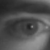

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_reshaped[30000].astype(int))

In [ ]:
labels[30000]

1

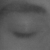

In [ ]:
cv2_imshow(X_reshaped[500].astype(int))

In [ ]:
labels[500]

0

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, labels_train, labels_test = train_test_split(X_reshaped, labels, test_size=0.1, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense

model = keras.Sequential([
                          Rescaling(1/255, input_shape=(50,50,1)),
                          Conv2D(64, kernel_size=(3, 3), activation='relu'),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(64, kernel_size=(3, 3), activation='relu'),
                          MaxPooling2D(pool_size=(2, 2)),
                          Conv2D(64, kernel_size=(3, 3), activation='relu'),
                          MaxPooling2D(pool_size=(2, 2)),
                          Flatten(),
                          Dense(64, activation='relu'),
                          Dense(1, activation='sigmoid')
                          ])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
model.fit(X_train, labels_train, validation_split=0.1, batch_size=16, epochs=4)

Epoch 1/4
2913/2913 [==============================] - 29s 5ms/step - loss: 0.1285 - accuracy: 0.9530 - val_loss: 0.0857 - val_accuracy: 0.9699
Epoch 2/4
2913/2913 [==============================] - 12s 4ms/step - loss: 0.0583 - accuracy: 0.9795 - val_loss: 0.0534 - val_accuracy: 0.9807
Epoch 3/4
2913/2913 [==============================] - 13s 5ms/step - loss: 0.0446 - accuracy: 0.9841 - val_loss: 0.0568 - val_accuracy: 0.9795
Epoch 4/4
2913/2913 [==============================] - 13s 5ms/step - loss: 0.0377 - accuracy: 0.9867 - val_loss: 0.0675 - val_accuracy: 0.9766


In [ ]:
model.evaluate(X_test, labels_test)

180/180 [==============================] - 1s 4ms/step - loss: 0.0553 - accuracy: 0.9783


[0.05526452139019966, 0.9782759547233582]

In [ ]:
np.around(model.predict(X_test[5].reshape(-1, 50, 50, 1)), decimals=3)

array([[1.]], dtype=float32)

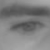

In [ ]:
cv2_imshow(X_test[5].astype(int))

In [ ]:
np.around(model.predict(X_test[6].reshape(-1, 50, 50, 1)), decimals=3)


array([[0.]], dtype=float32)

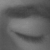

In [ ]:
cv2_imshow(X_test[6].astype(int))

In [ ]:
np.around(model.predict(X_test[69].reshape(-1, 50, 50, 1)), decimals=3)


array([[0.999]], dtype=float32)

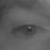

In [ ]:
cv2_imshow(X_test[69].astype(int))

# Detecting eye in selfie

In [ ]:
#from google.colab.patches import cv2_imshow

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def plot_predict(file_name):
  PATH = "/content/" + file_name

  img=cv2.imread(PATH)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(img_gray, 1.2, 5)

  eye_imgs = []
  for (x,y,w,h) in faces:
          #cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
          roi_gray = img_gray[y:y+h, x:x+w]

          eyes = eye_cascade.detectMultiScale(roi_gray)
          #print(len(eyes))

          for i, (ex, ey, ew, eh) in enumerate(eyes):
            crop_img = roi_gray[ey: ey + eh + 10, ex: ex + ew + 10]
            eye_imgs.append(crop_img)
            # The commented line below saves the eyes to a file
            #cv2.imwrite('/content/eye' + str(count) + '.jpg', crop_img)
            
            if i == 1:
              break
                #cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

  if eye_imgs == []:
    print('no eyes found, predict 0')
    #return 0

  else:

    preds = np.array([])
    for crop_img in eye_imgs:
      image_array = np.array(crop_img)
      image_array_resized = cv2.resize(image_array, dsize=(50,50))
      if image_array_resized.mean() < 50:
        #print('dark eyes')
        image_array_resized+=50
        image_array_resized = np.clip(image_array_resized, 0, 255)
      elif image_array_resized.mean() > 200:
        #print('bright eyes')
        image_array_resized-=50
        image_array_resized = np.clip(image_array_resized, 0, 255)
      
      print(np.around(model.predict((image_array_resized+50).reshape(-1, 50, 50, 1)), decimals=3)[0][0])
      preds = np.append(preds, np.around(model.predict((image_array_resized+50).reshape(-1, 50, 50, 1)), decimals=3)[0][0])
      cv2_imshow(image_array_resized.astype(int))

    idx = np.argmax(np.abs(preds - 0.5))
    best_pred = preds[idx]
    print(f'final pred = {best_pred}')
    #return best_pred

Eye Open = 1

1.0


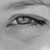

1.0


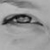

final pred = 1.0


In [ ]:
plot_predict('merav.png')

1.0


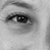

1.0


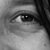

final pred = 1.0


In [ ]:
plot_predict('mor.png')

0.0


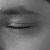

0.0


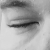

final pred = 0.0


In [ ]:
plot_predict('bailey.png')

In [ ]:
model.save('my_model')

In [ ]:
new_model = tf.keras.models.load_model('my_model')

Full prediction

In [ ]:

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + ‘haarcascade_frontalface_default.xml’)
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + ‘haarcascade_eye.xml’)

def plot_predict(file_name):
  PATH = “/content/” + file_name
  img=cv2.imread(PATH)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(img_gray, 1.2, 5)
  eye_imgs = []
  for (x,y,w,h) in faces:
          roi_gray = img_gray[y:y+h, x:x+w]
          eyes = eye_cascade.detectMultiScale(roi_gray)
          for i, (ex, ey, ew, eh) in enumerate(eyes):
            crop_img = roi_gray[ey: ey + eh + 10, ex: ex + ew + 10]
            eye_imgs.append(crop_img)
            # The line below saves the eyes to a file
            cv2.imwrite(‘/content/eye’ + str(count) + ‘.jpg’, crop_img)
            if i == 1:
              break
                #cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
  if eye_imgs == []:
    print(‘no eyes found, predict 0’)
  else:
    crop_img1, crop_img2 = eye_imgs
    preds = np.array([])
    for crop_img in eye_imgs:
      image_array = np.array(crop_img)
      image_array_resized = cv2.resize(image_array, dsize=(50,50))
      if image_array_resized.mean() < 50:
        # dark eyes, adjust lighting
        image_array_resized+=50
        image_array_resized = np.clip(image_array_resized, 0, 255)
      elif image_array_resized.mean() > 200:
        # bright eyes, adjust lighting
        image_array_resized-=50
        image_array_resized = np.clip(image_array_resized, 0, 255)
      print(np.around(model.predict((image_array_resized+50).reshape(-1, 50, 50, 1)), decimals=3)[0][0])
      preds = np.append(preds, np.around(model.predict((image_array_resized+50).reshape(-1, 50, 50, 1)), decimals=3)[0][0])
      cv2_imshow(image_array_resized.astype(int))
    idx = np.argmax(np.abs(preds - 0.5))
    best_pred = preds[idx]
    print(f’final pred = {best_pred}’)
    return best_pred